In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [7]:
data_dir = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

In [17]:
data_dirs = [os.path.join(data_dir, dir_) for dir_ in os.listdir(data_dir) if "processed" not in dir_]

In [18]:
data_dirs

['D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\daisy',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\dandelion',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\rose',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\sunflower',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\tulip']

In [16]:
import random
from skimage import io

class loading_and_splitting:
    
    def __init__(self, data_dirs, dims, channels=3, target_dir=data_dir):
        self.total_images = 0
        self.minh = np.inf
        self.minw = np.inf
        self.dims = dims
        self.channels = channels
        self.target_dir = target_dir
        self.data_dirs = data_dirs
        
        self.header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        self.sample_list = [random.sample(range(len(os.listdir(path))), 
                                          len(os.listdir(path))) for path in data_dirs]
        for item in self.sample_list:
            self.total_images += len(item)
        self.generate_samples()
        
    
    def generate_csvs(self):
        header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        for set_ in ["train", "valid", "test"]:
            with open(os.path.join(self.target_dir, f"{set_}.csv"), "w") as f:
                df = pd.DataFrame(list(), columns=header_list)
                df.to_csv(f, index=False)
                
    def generate_samples(self):
        self.sample_seq = random.sample(range(self.total_images), self.total_images)
        self.train_seq = self.sample_seq[:int(len(self.sample_seq)*0.8)]
        self.valid_seq = self.sample_seq[int(len(self.sample_seq)*0.8):int(len(self.sample_seq)*0.9)]
        self.test_seq = self.sample_seq[int(len(self.sample_seq)*0.9):]
    
    def crop_image(self, image):
        h, w, d = image.shape
        if h >= self.minh and w >= self.minw:
            image = image[int(h/2)-64:int(h/2)+64, 
                          int(w/2)-64:int(w/2)+64, 
                          :]
            return image
    
    def shuffle_and_save(self):
        empty = []
        train = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        valid = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        test = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        count = 0
        while len(empty) != len(self.data_dirs):
            sel_dir = np.random.randint(0, len(self.data_dirs))
            if sel_dir in empty: continue
            dir_ = self.data_dirs[sel_dir]
            if not self.sample_list[sel_dir]:
                empty.append(sel_dir)
            else:
                count += 1
                print(f"Processing: {count}")
                sel_image = self.sample_list[sel_dir].pop()
                image = io.imread(os.path.join(dir_, os.listdir(dir_)[sel_image]))
                
                h, w, d = image.shape
                if h < self.minh: self.minh = h
                if w < self.minw: self.minw = w
                if self.minh < self.dims[0]: self.minh = self.dims[0]
                if self.minw < self.dims[1]: self.minw = self.dims[1]
                
                image = self.crop_image(image)
                
                if not isinstance(image, np.ndarray): continue
                if sel_image in self.train_seq: 
                    train = np.append(train, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.valid_seq: 
                    valid = np.append(valid, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.test_seq: 
                    test = np.append(test, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
        
        train = train[1:, :]
        valid = valid[1:, :]
        test = test[1:, :]
        
        for prefix, arr in zip(["train", "valid", "test"], [train, valid, test]):
            self.split_and_save(arr, os.path.join(self.target_dir, "processed", prefix), prefix)
        
    def split_and_save(self, arr, target_dir, prefix, split_count=10):
        os.makedirs(target_dir, exist_ok=True)
        for i in range(split_count):
            df = pd.DataFrame(arr[i*int(arr.shape[0]//split_count):(i+1)*int(arr.shape[0]//split_count), :], 
                             columns=self.header_list)
            df.to_csv(os.path.join(target_dir, "{}_{}.csv".format(prefix, i+1)), index=False)

In [11]:
dims = (128, 128)
channels = 3
n_features = dims[0] * dims[1] * channels
# ls = loading_and_splitting(data_dirs=data_dirs, dims=dims, channels=channels, target_dir=data_dir)
# ls.shuffle_and_save()

In [12]:
data_dir = os.path.join(data_dir, "processed")
train_paths = [f"{os.path.join(data_dir, 'train')}\\{item}" for item in os.listdir(os.path.join(data_dir, "train"))]
valid_paths = [f"{os.path.join(data_dir, 'valid')}\\{item}" for item in os.listdir(os.path.join(data_dir, "valid"))]
test_paths = [f"{os.path.join(data_dir, 'test')}\\{item}" for item in os.listdir(os.path.join(data_dir, "test"))]

In [13]:
def preprocess(line):
    defs = [tf.constant([], dtype = tf.float32)] * (n_features + 1)
    xy = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(xy[:-1])
    y = tf.stack(xy[-1:])
    
    X = tf.reshape(X, [128, 128, 3])
    return X/255., y


n_readers = 5
filepaths = tf.data.Dataset.list_files(train_paths, seed=42)
dataset = filepaths.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)
dataset = dataset.map(preprocess)

In [14]:
images = []
for line in dataset.take(2):
    print(line[1])
    images.append(line[0])

tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([2.], shape=(1,), dtype=float32)


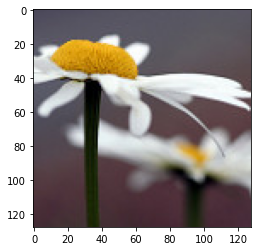

In [15]:
plt.imshow(images[0])